In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
import os
# FOLDERNAME = "20-21/Spring Quarter/CS 197/CS197/cs197"
# FOLDERNAME = "CS197/cs197/"
FOLDERNAME = "3_SPR/cs197/fewshot-code"
%cd /content/drive/My\ Drive/$FOLDERNAME

BASE = os.path.join('/content/drive/My Drive', FOLDERNAME)
sys.path.append(BASE)

/content/drive/My Drive/3_SPR/cs197/fewshot-code


In [3]:
#@title
%reload_ext autoreload
%autoreload 2
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
!apt install libomp-dev
!pip install faiss-gpu

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

from collections import OrderedDict
import IPython.display
import itertools
import os
from tqdm.notebook import tqdm

from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import skimage #Has some images in here - check original "Interacting with CLIP.ipynb" document
import torch
from torch.utils.data import DataLoader

import faiss
from faissKNeighbors import FaissKNeighbors
from prototype import Prototype
from prototypevector import PrototypeVector
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from utils.data_utils import *
from utils.image_utils import *
from utils.text_utils import *
from utils.plotting import *
from linear_classifier import *

print("Torch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")

plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

--2021-06-01 06:59:47--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.69, 13.107.213.69, 2620:1ec:bdf::69, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.05s   

2021-06-01 06:59:47 (26.5 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
CUDA version: 11.0
Torch

In [4]:
#@title
MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",    
}
model_dir = os.path.join(BASE, "model.pt")
# ! wget {MODELS["ViT-B/32"]} -O model.pt

clip_model = torch.jit.load(model_dir).cuda().eval()
input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length.item()
vocab_size = clip_model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

DATASETS_DIR = os.path.join(BASE, 'datasets')
train_dataset_raw = CIFAR10(DATASETS_DIR, train=True, transform=ToTensor())
loader = DataLoader(train_dataset_raw, batch_size=len(train_dataset_raw))
images, _ = next(iter(loader))
image_mean, image_std = images.mean(), images.std()

In [6]:
train_dataset = CIFAR10(DATASETS_DIR, train=True, transform=Compose([ToTensor(), Normalize(image_mean, image_std), Resize(224) ]))
test_dataset = CIFAR10(DATASETS_DIR, train=False, transform=Compose([ToTensor(), Normalize(image_mean, image_std), Resize(224) ]))
test_vectors, test_labels = encodeDataset(test_dataset, clip_model.encode_image, device=device, batch_size=512)
train_vectors, train_labels = encodeDataset(train_dataset, clip_model.encode_image, device=device, batch_size=512)

In [ ]:
print (test_vectors.device)

cpu


# Linear classifier experiments

In [7]:
def run_experiments(train_vectors, train_labels, test_vectors, test_labels, k_min, k_max, trials_per_k):
  accuracies = {}
  stds = {}
  for k in tqdm(range(k_min, k_max + 1), desc="k"):
    trial_accs = []
    for t in tqdm(range(trials_per_k), desc="trials"):
      train_data_dict = sample_classes(train_vectors, train_labels, per_class = k)

      lc_train_vectors = list(map(lambda c: torch.stack(random.sample(list(train_data_dict[c]), k)), range(10)))
      lc_train_vectors = torch.cat(lc_train_vectors)
      lc_train_labels = torch.tensor(list(range(10))).unsqueeze(1).expand(-1, k).flatten()

      classifier = linear_classifier(lc_train_vectors, lc_train_labels, 10, epochs=1000, lr=1e-1, device=device, print_every = 0).to(device)

      with torch.no_grad():
        pred_scores = classifier(test_vectors.to(device)).cpu()
      preds = torch.argmax(pred_scores, dim=1)
      test_acc = torch.mean((preds == test_labels).float())
      # print("k = {}, acc = {}".format(k, test_acc))
      trial_accs.append(test_acc.detach())

    accuracies[k] = trial_accs

    print("k = {}, mean acc = {}, mean std = {}".format(k, np.mean(accuracies[k]), np.std(accuracies[k])))
  
  return accuracies

In [8]:
accuracies = run_experiments(train_vectors, train_labels, test_vectors, test_labels, 1, 100, 10)


k = 1, mean acc = 0.6206899881362915, mean std = 0.06490351259708405



k = 2, mean acc = 0.7459800243377686, mean std = 0.04198627546429634



k = 3, mean acc = 0.7868300080299377, mean std = 0.029052674770355225



k = 4, mean acc = 0.8044300079345703, mean std = 0.023952702060341835



k = 5, mean acc = 0.83051997423172, mean std = 0.012835095636546612



k = 6, mean acc = 0.8422200083732605, mean std = 0.013913287781178951



k = 7, mean acc = 0.8418499827384949, mean std = 0.014200516045093536



k = 8, mean acc = 0.8496800661087036, mean std = 0.008733591996133327



k = 9, mean acc = 0.8569299578666687, mean std = 0.009672136977314949



k = 10, mean acc = 0.8594599962234497, mean std = 0.007024545222520828



k = 11, mean acc = 0.8654699325561523, mean std = 0.007851885631680489



k = 12, mean acc = 0.8607799410820007, mean std = 0.008037641644477844



k = 13, mean acc = 0.8613100051879883, mean std = 0.005835316609591246



k = 14, mean acc = 0.868630051612854, mean std = 0.0050315107218921185



k = 15, mean acc = 0.8717899322509766, mean std = 0.0050971428863704205



k = 16, mean acc = 0.8697600364685059, mean std = 0.00724088354036212



k = 17, mean acc = 0.8758900761604309, mean std = 0.005347231402993202



k = 18, mean acc = 0.8711299896240234, mean std = 0.010358093306422234



k = 19, mean acc = 0.875749945640564, mean std = 0.004680648446083069



k = 20, mean acc = 0.8739699125289917, mean std = 0.0061657242476940155



k = 21, mean acc = 0.8755399584770203, mean std = 0.002304858062416315



k = 22, mean acc = 0.8754900097846985, mean std = 0.0038658692501485348



k = 23, mean acc = 0.8787299990653992, mean std = 0.004060302395373583



k = 24, mean acc = 0.8802000284194946, mean std = 0.003758189966902137



k = 25, mean acc = 0.8793099522590637, mean std = 0.0054274206049740314



k = 26, mean acc = 0.8806600570678711, mean std = 0.007029400207102299



k = 27, mean acc = 0.8819700479507446, mean std = 0.0028937971219420433



k = 28, mean acc = 0.883430004119873, mean std = 0.0028913847636431456



k = 29, mean acc = 0.8834199905395508, mean std = 0.0052963728085160255



k = 30, mean acc = 0.8834500312805176, mean std = 0.004318165127187967



k = 31, mean acc = 0.8837000131607056, mean std = 0.004344652406871319



k = 32, mean acc = 0.8830599784851074, mean std = 0.002967892913147807



k = 33, mean acc = 0.8846500515937805, mean std = 0.0031113470904529095



k = 34, mean acc = 0.8837800025939941, mean std = 0.004416066221892834



k = 35, mean acc = 0.8831800222396851, mean std = 0.0045461589470505714



k = 36, mean acc = 0.888189971446991, mean std = 0.003106908407062292



k = 37, mean acc = 0.8874199986457825, mean std = 0.004558895248919725



k = 38, mean acc = 0.8857900500297546, mean std = 0.0038179708644747734



k = 39, mean acc = 0.8866699934005737, mean std = 0.006333411205559969



k = 40, mean acc = 0.8869400024414062, mean std = 0.0032333298586308956



k = 41, mean acc = 0.8885499835014343, mean std = 0.0028744563460350037



k = 42, mean acc = 0.8874799609184265, mean std = 0.0043171364814043045



k = 43, mean acc = 0.8872900009155273, mean std = 0.003138289088383317



k = 44, mean acc = 0.8891099691390991, mean std = 0.002290169708430767



k = 45, mean acc = 0.8903200030326843, mean std = 0.003098640125244856



k = 46, mean acc = 0.8874799609184265, mean std = 0.003605225821956992



k = 47, mean acc = 0.8889200091362, mean std = 0.0027784151025116444



k = 48, mean acc = 0.8904598951339722, mean std = 0.004300282336771488



k = 49, mean acc = 0.8892099261283875, mean std = 0.004577654413878918



k = 50, mean acc = 0.8919699788093567, mean std = 0.002742286305874586



k = 51, mean acc = 0.8920300602912903, mean std = 0.0024277737829834223



k = 52, mean acc = 0.8910599946975708, mean std = 0.003726990194991231



k = 53, mean acc = 0.8899900317192078, mean std = 0.004419370088726282



k = 54, mean acc = 0.892509937286377, mean std = 0.004125636536628008



k = 55, mean acc = 0.8911800384521484, mean std = 0.003480462357401848



k = 56, mean acc = 0.8908699750900269, mean std = 0.005627441219985485



k = 57, mean acc = 0.8907899856567383, mean std = 0.0043031321838498116



k = 58, mean acc = 0.8923700451850891, mean std = 0.004035360179841518



k = 59, mean acc = 0.8923400044441223, mean std = 0.003527675988152623



k = 60, mean acc = 0.8917900323867798, mean std = 0.004993288777768612



k = 61, mean acc = 0.8919599652290344, mean std = 0.0027269807178527117



k = 62, mean acc = 0.8919399976730347, mean std = 0.0017715569119900465



k = 63, mean acc = 0.8925299644470215, mean std = 0.004414067603647709



k = 64, mean acc = 0.894260048866272, mean std = 0.0027608699165284634



k = 65, mean acc = 0.8917299509048462, mean std = 0.0040892637334764



k = 66, mean acc = 0.8911499977111816, mean std = 0.0032912681344896555



k = 67, mean acc = 0.8921600580215454, mean std = 0.0036307545378804207



k = 68, mean acc = 0.8934899568557739, mean std = 0.0032672390807420015



k = 69, mean acc = 0.8937600255012512, mean std = 0.003458094783127308



k = 70, mean acc = 0.8951398730278015, mean std = 0.0036732081789523363



k = 71, mean acc = 0.8942100405693054, mean std = 0.0026508287992328405



k = 72, mean acc = 0.8954499363899231, mean std = 0.0025827204808592796



k = 73, mean acc = 0.8928200006484985, mean std = 0.0031111997086554766



k = 74, mean acc = 0.8943700790405273, mean std = 0.0026073192711919546



k = 75, mean acc = 0.8954299688339233, mean std = 0.003035147674381733



k = 76, mean acc = 0.8956199884414673, mean std = 0.0033168597146868706



k = 77, mean acc = 0.8950899839401245, mean std = 0.003087220247834921



k = 78, mean acc = 0.896619975566864, mean std = 0.002002400578930974



k = 79, mean acc = 0.8964699506759644, mean std = 0.003043368924409151



k = 80, mean acc = 0.8947799801826477, mean std = 0.0030052578076720238



k = 81, mean acc = 0.8957799673080444, mean std = 0.0039012255147099495



k = 82, mean acc = 0.8961600065231323, mean std = 0.0015976188005879521



k = 83, mean acc = 0.8969300389289856, mean std = 0.003071502083912492



k = 84, mean acc = 0.8983899354934692, mean std = 0.0033625750802457333



k = 85, mean acc = 0.895159900188446, mean std = 0.003451139898970723



k = 86, mean acc = 0.8982300758361816, mean std = 0.0030020265839993954



k = 87, mean acc = 0.8958900570869446, mean std = 0.0026151284109801054



k = 88, mean acc = 0.8955599665641785, mean std = 0.0021251807920634747



k = 89, mean acc = 0.8952400088310242, mean std = 0.0030206642113626003



k = 90, mean acc = 0.896310031414032, mean std = 0.002262501511722803



k = 91, mean acc = 0.8970500230789185, mean std = 0.0036241556517779827



k = 92, mean acc = 0.8971600532531738, mean std = 0.003947710618376732



k = 93, mean acc = 0.8973199725151062, mean std = 0.0029054423794150352



k = 94, mean acc = 0.898919939994812, mean std = 0.0035524223931133747



k = 95, mean acc = 0.8987800478935242, mean std = 0.002338727703318



k = 96, mean acc = 0.8970600366592407, mean std = 0.003178739920258522



k = 97, mean acc = 0.8967200517654419, mean std = 0.004930679686367512



k = 98, mean acc = 0.8985199928283691, mean std = 0.0024198328610509634



k = 99, mean acc = 0.897290050983429, mean std = 0.002422170713543892



k = 100, mean acc = 0.8964800834655762, mean std = 0.002605308312922716



In [ ]:
import json
with open(os.path.join(BASE, 'results/linearclassifier.json'), 'w') as f:
  json.dump(accuracies, f)

In [47]:
import json
with open(os.path.join(BASE, 'results/linearclassifier.json')) as f:
  accuracies = json.load(f)

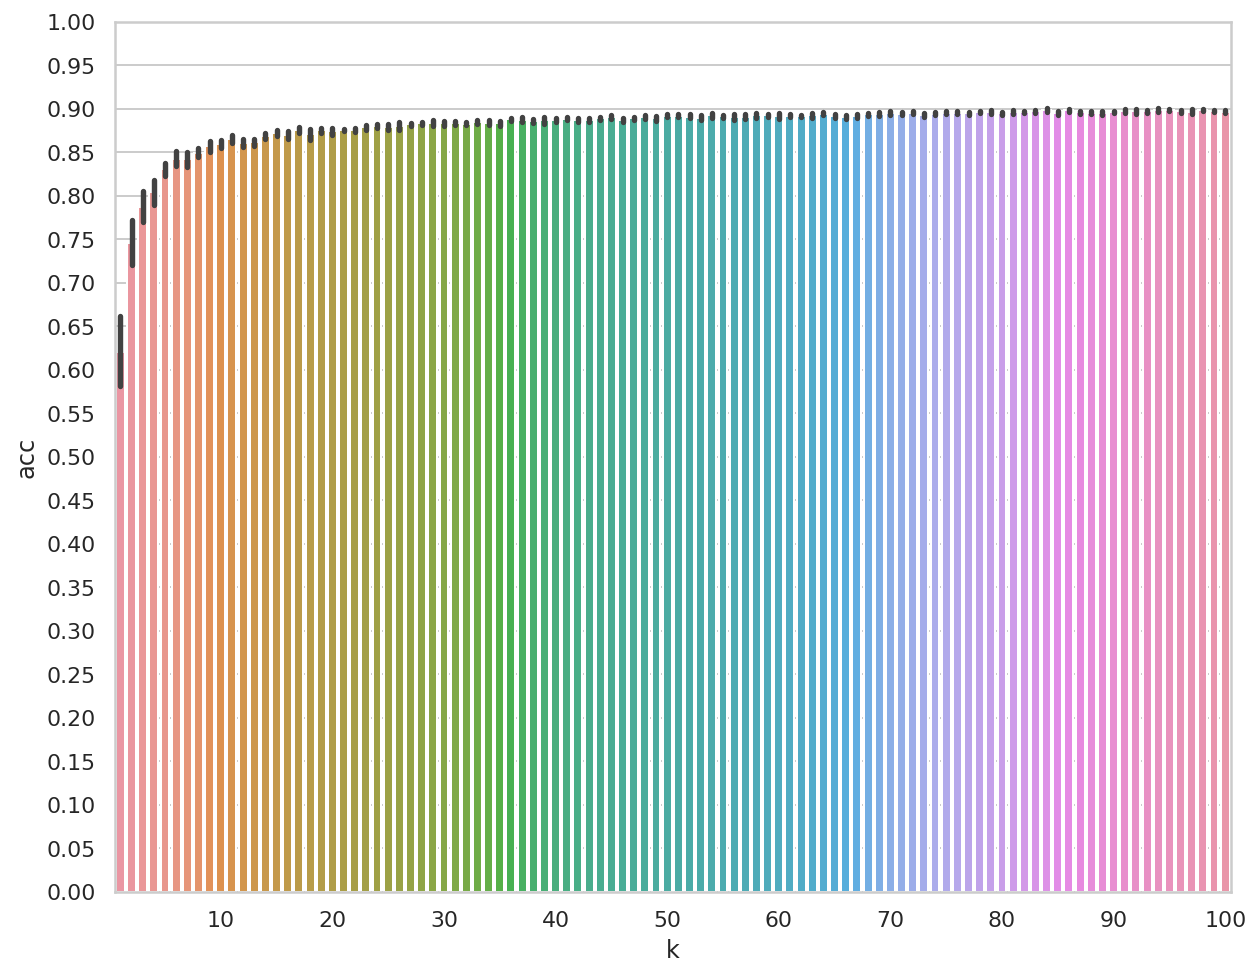

In [72]:
data100 = np.array([(int(k), np.array(acc)) for k, acc in accuracies.items()], dtype=object)
plot_run_accuracies(data100)

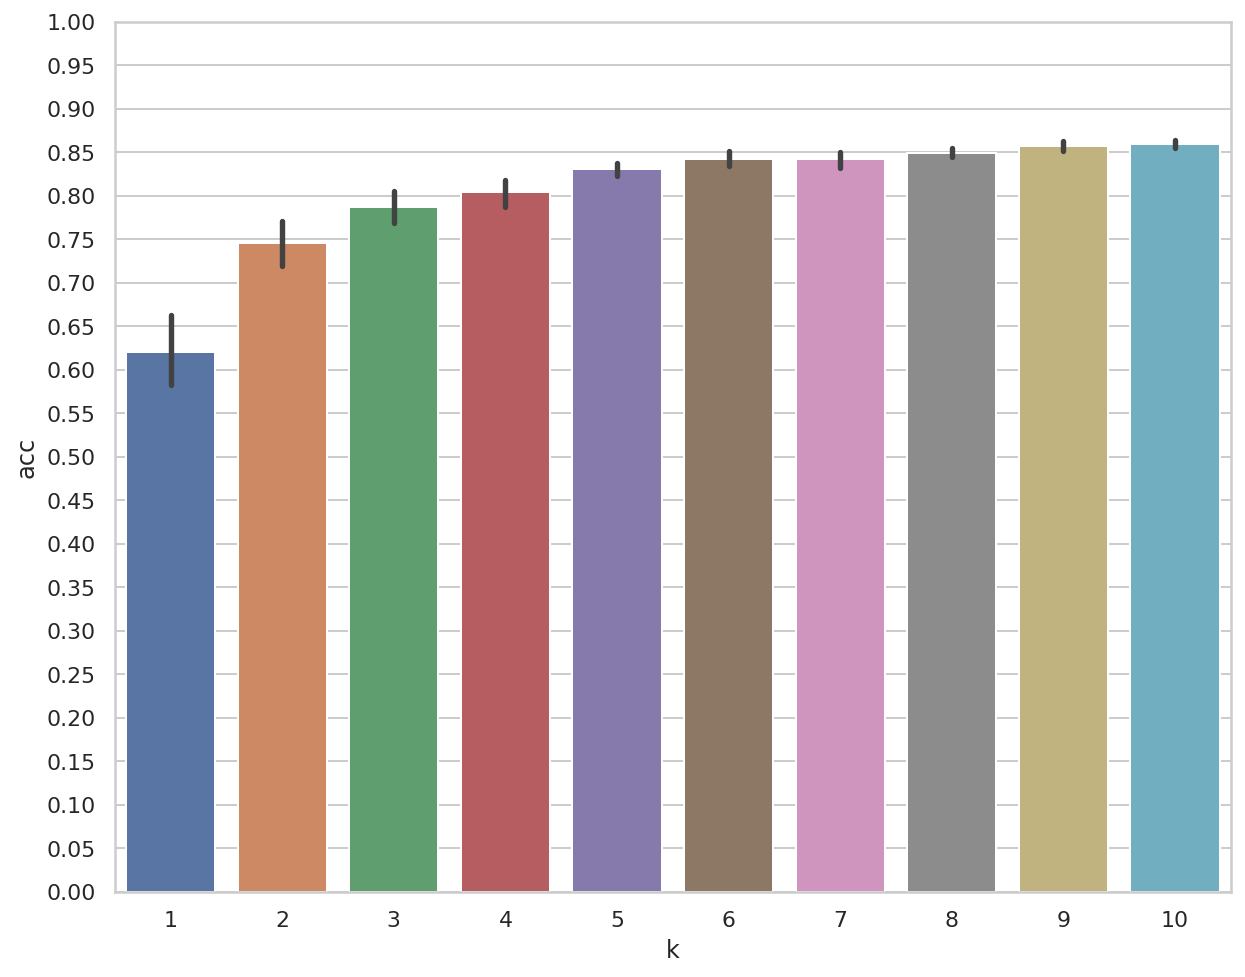

In [71]:
data10 = np.array([(int(k), np.array(acc)) for k, acc in accuracies.items() if int(k) <= 10], dtype=object)
plot_run_accuracies(data10, xtick_interval=1)